# Dose response curves

First we generate correlation matrices to visualize the data;

Then we extract the values we want (comparison between replicates or comparison to poscontrol, DMSO in our case) and organize them as x, x_log and y

Then we plot linear and non-linear regression

And calculate the EC50 from a non-linear regression function (same from GraphPad prism)


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import statistics
import plotly.graph_objects as go
from scipy.optimize import curve_fit
import pycytominer
import utilitary as util
%load_ext autoreload
%autoreload 2

# Inputs

In [2]:
path = r'G:\My Drive\Analysis\AgNP_Viability\notebooks\output'
# file = r'\2_FeatSelect_negconNonTrAndAgNP.csv'
file = r'\Pycombat_negconNonTrAndAgNP.csv'
plates =  ['211008_092824_Plate_1', '211015_065907_Plate_1', '211020_085918_Plate_1']

# Import CSV and create new label column

- For the label column, important to have some prefix related to any of the compartments so we can keep this column moving forward (in this case we're adding Cells prefix to it)

In [3]:
df_selected = pd.read_csv(path+file)

In [4]:
df_selected

,Unnamed: 0,Metadata_plate_map_name,Metadata_Compound,Metadata_NPSize_nm,Metadata_Concentration_mgml,Metadata_Concentration_uM,Metadata_Cell,Metadata_control_type,Metadata_Plate,Metadata_Well,...,Nuclei_Texture_Correlation_CorrPI_20_01_256,Nuclei_Texture_Correlation_CorrPI_20_02_256,Nuclei_Texture_Correlation_CorrPI_20_03_256,Nuclei_Texture_Correlation_CorrPI_5_00_256,Nuclei_Texture_Correlation_CorrPI_5_01_256,Nuclei_Texture_DifferenceVariance_CorrGFP_20_03_256,Nuclei_Texture_Entropy_CorrGFP_10_01_256,Nuclei_Texture_Entropy_CorrGFP_20_02_256,Nuclei_Texture_Entropy_CorrPI_20_01_256,Nuclei_Texture_SumVariance_CorrGFP_20_03_256
0,0,platemap_agnp,DMSO,0.0,10.000000,10.0000,Huh7,NaN,211020_085918_Plate_1,B2,...,0.608289,3.566581,-0.653867,1.492880,2.039300,-2.468198,3.272155,6.033045,2.919238,4.700772
1,1,platemap_agnp,AgNP,40.0,0.000010,0.0011,Huh7,negcon,211020_085918_Plate_1,B3,...,-0.873622,1.887518,0.097703,1.152421,1.770724,-2.621610,3.435563,5.763305,3.218159,6.064394
2,2,platemap_agnp,AgNP,40.0,0.000020,0.0022,Huh7,NaN,211020_085918_Plate_1,B4,...,0.588280,3.389238,0.567903,0.770106,1.372137,-1.504976,2.182819,4.346806,2.198411,2.573727
3,3,platemap_agnp,AgNP,40.0,0.000039,0.0043,Huh7,NaN,211020_085918_Plate_1,B5,...,-0.506598,1.219463,-0.091590,0.457024,0.917760,-0.847773,1.570428,2.670014,1.054476,1.167264
4,4,platemap_agnp,AgNP,40.0,0.000078,0.0087,Huh7,NaN,211020_085918_Plate_1,B6,...,0.028479,3.577844,-0.691614,1.906422,2.287537,-2.688456,3.712568,6.199087,3.553523,5.786424
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,175,platemap_agnp,AgNP,100.0,0.001300,0.1390,Huh7,NaN,211015_065907_Plate_1,G7,...,-1.609588,-0.969497,-0.620760,1.070808,1.263570,-0.480760,0.620818,0.885798,0.323717,0.937675
176,176,platemap_agnp,AgNP,100.0,0.002500,0.2780,Huh7,NaN,211015_065907_Plate_1,G8,...,-1.808268,0.738709,-2.456074,2.383422,3.048820,-1.169227,1.557504,2.464389,2.128696,2.569479
177,177,platemap_agnp,AgNP,100.0,0.005000,0.5560,Huh7,NaN,211015_065907_Plate_1,G9,...,-2.313390,-0.576878,-5.432049,2.277962,2.241149,-1.188461,1.786819,1.480264,1.113901,3.221643
178,178,platemap_agnp,AgNP,100.0,0.010000,1.1110,Huh7,NaN,211015_065907_Plate_1,G10,...,-6.811985,-3.750569,-11.062377,2.298193,3.719219,-1.590819,1.896622,0.459668,0.132830,4.439130


In [8]:
#new column
df_selected['Cells_CompoundSizeCnc'] = df_selected['Metadata_Compound'] + ' ' + df_selected['Metadata_NPSize_nm'].astype(str) + ' ' + df_selected['Metadata_Concentration_uM'].astype(str)
df_selected['Metadata_CompoundSize'] = df_selected['Metadata_Compound'] + ' ' + df_selected['Metadata_NPSize_nm'].astype(str)
df_selected['Metadata_CompoundSizeCnc'] = df_selected['Metadata_Compound'] + ' ' + df_selected['Metadata_NPSize_nm'].astype(str) + ' ' + df_selected['Metadata_Concentration_uM'].astype(str)

In [9]:
list_cmp = df_selected['Cells_CompoundSizeCnc'].unique()

# Correlation matrix

AIM - to calculate a correlation matrix for each plate 

HOW
1) Determine a new dataframe containing only the nuclei, cells and cytoplasm columns 
2) Set the index as the Cells_CompoundSizeCnc (because you can only have one metadata column at this step), and then transpose the dataframe
3) Calculate the correlation matrix for each transposed df (one for each plate)

In [10]:
df_corr = util.corr_matrix_per_plate(df_selected, plates, plot_joined_replicates=True, metadata_column = 'Cells_CompoundSizeCnc')

Shape of each DataFrame, split by plate (60, 355)
Shape of each DataFrame, split by plate (60, 355)
Shape of each DataFrame, split by plate (60, 355)


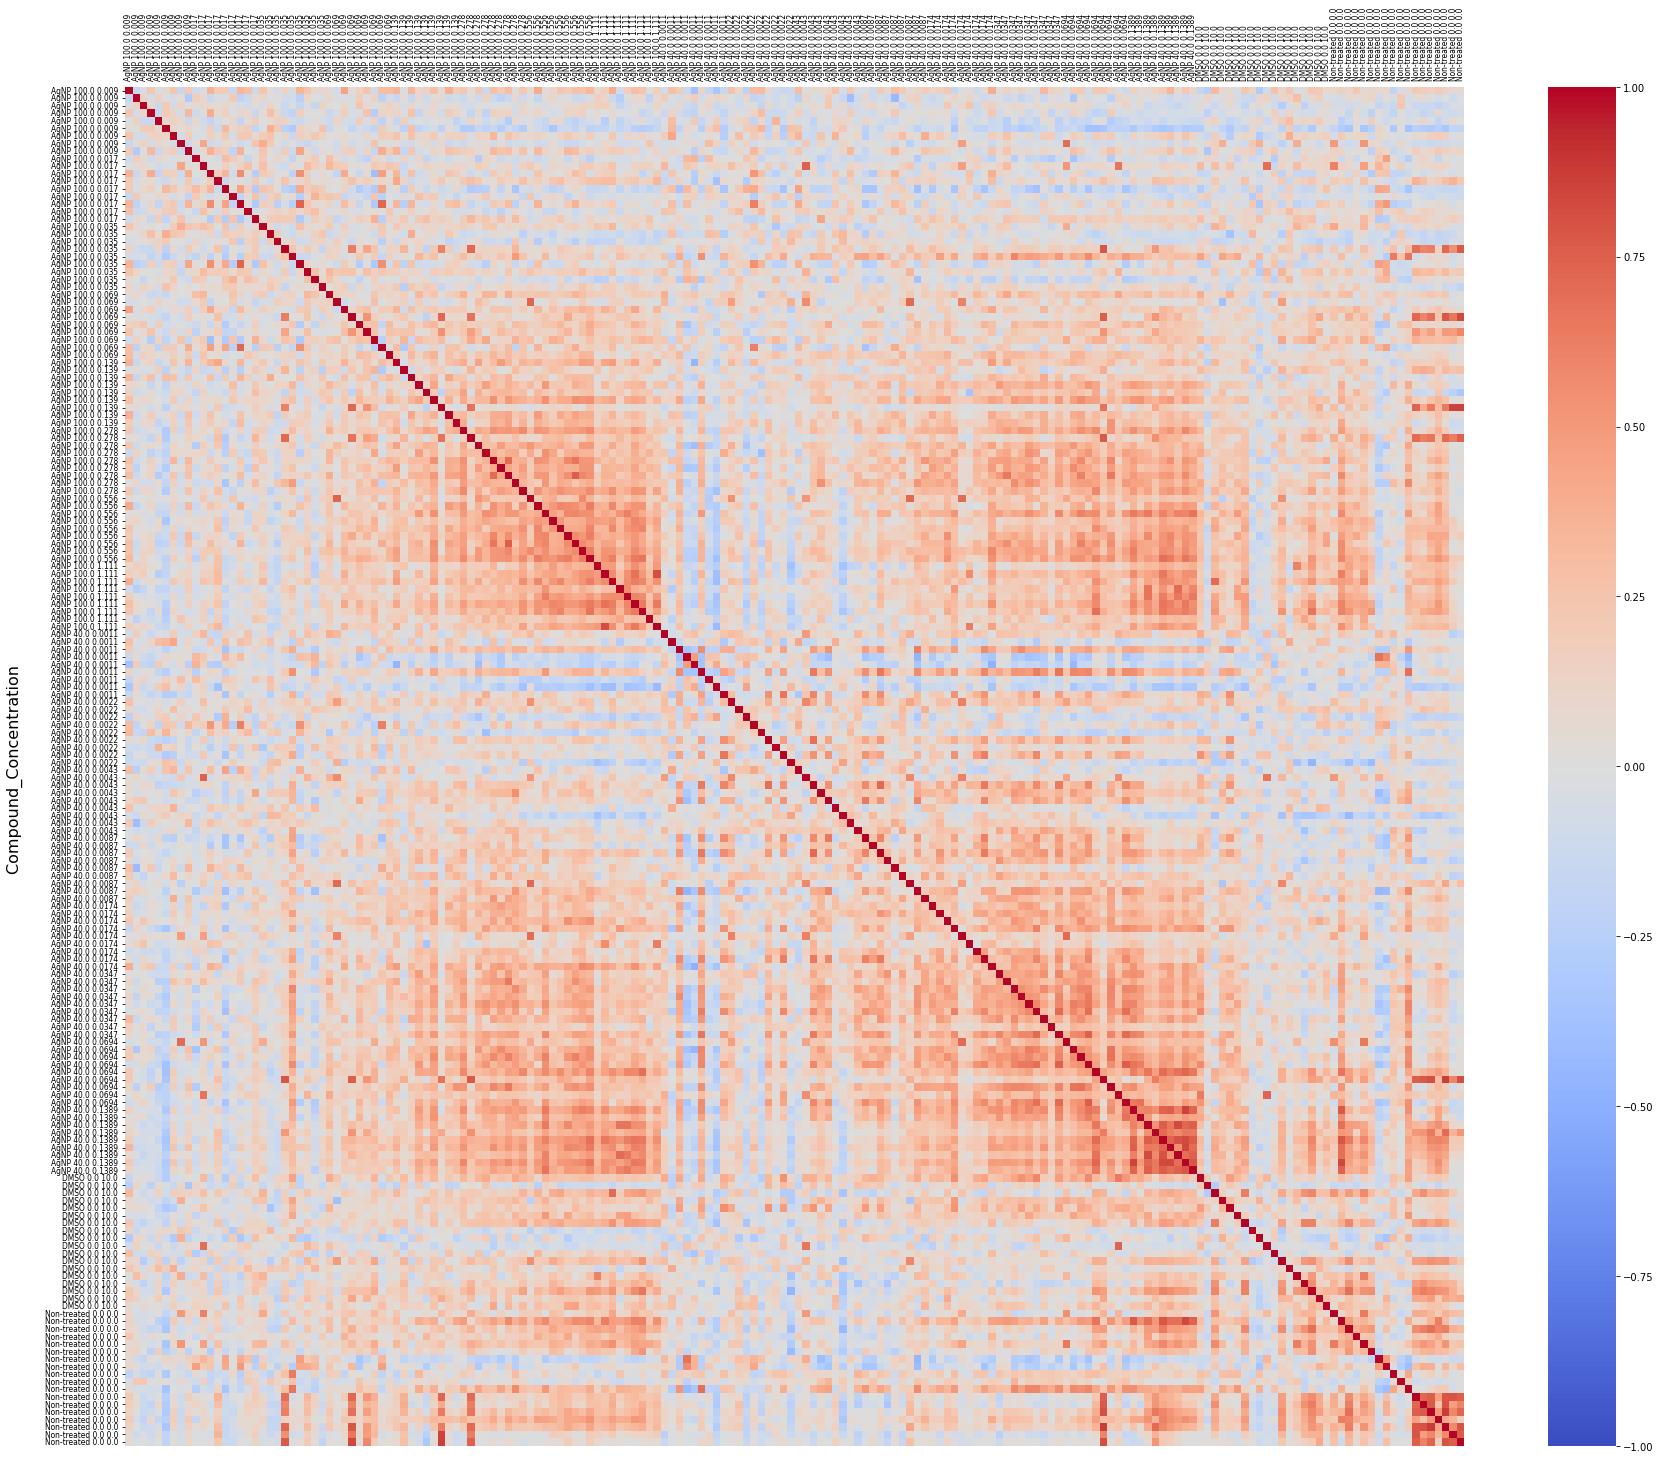

In [11]:
util.plot_corr_matrix(df_corr, labelsize=7.5)

# Correlation matrix for specific samples

Shape of each DataFrame, split by plate (36, 356)
Shape of each DataFrame, split by plate (36, 356)
Shape of each DataFrame, split by plate (36, 356)
Shape of each DataFrame, split by plate (36, 356)
Shape of each DataFrame, split by plate (36, 356)
Shape of each DataFrame, split by plate (36, 356)


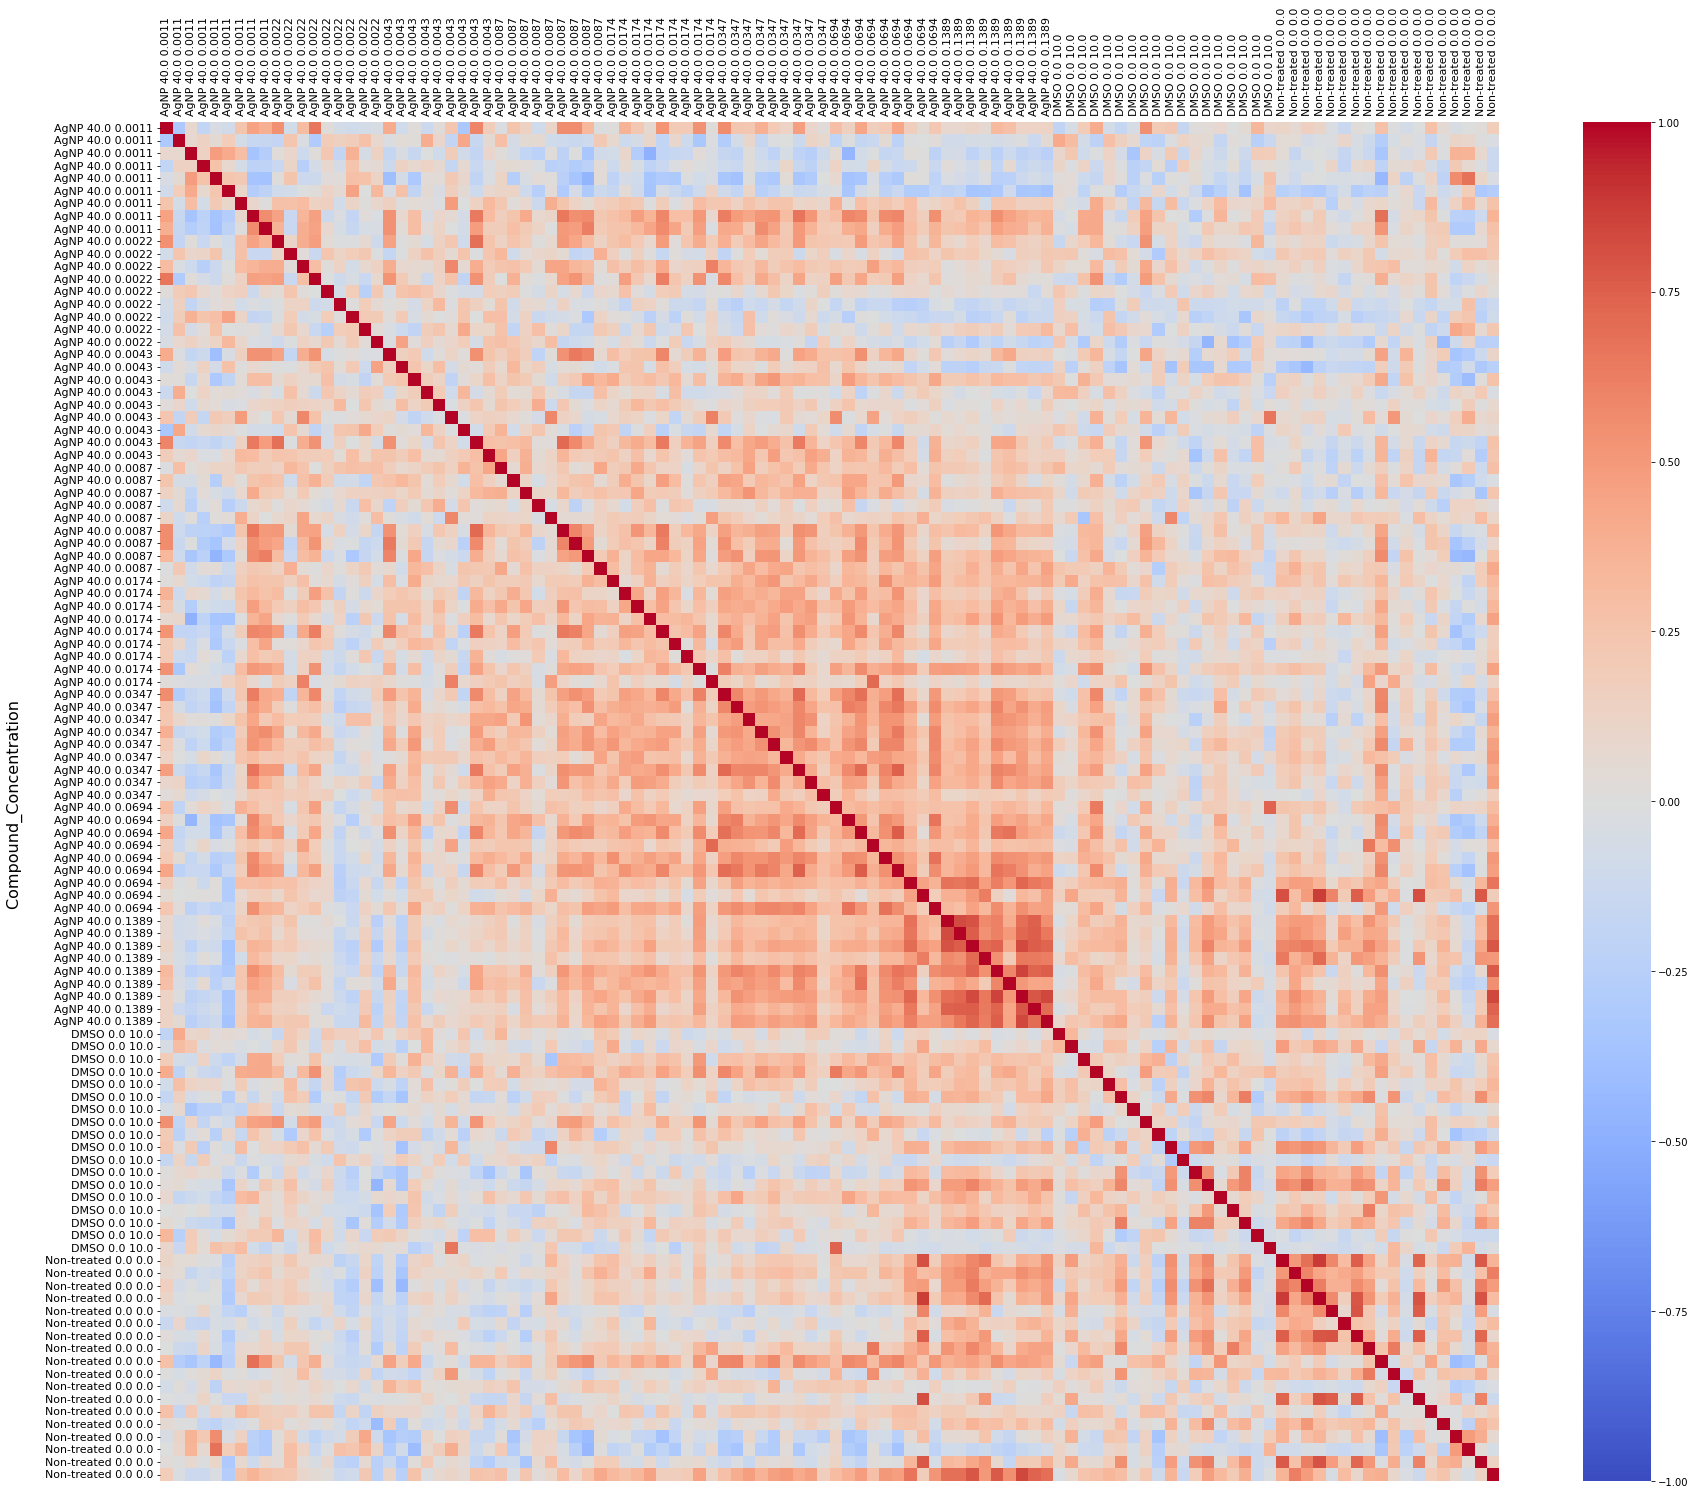

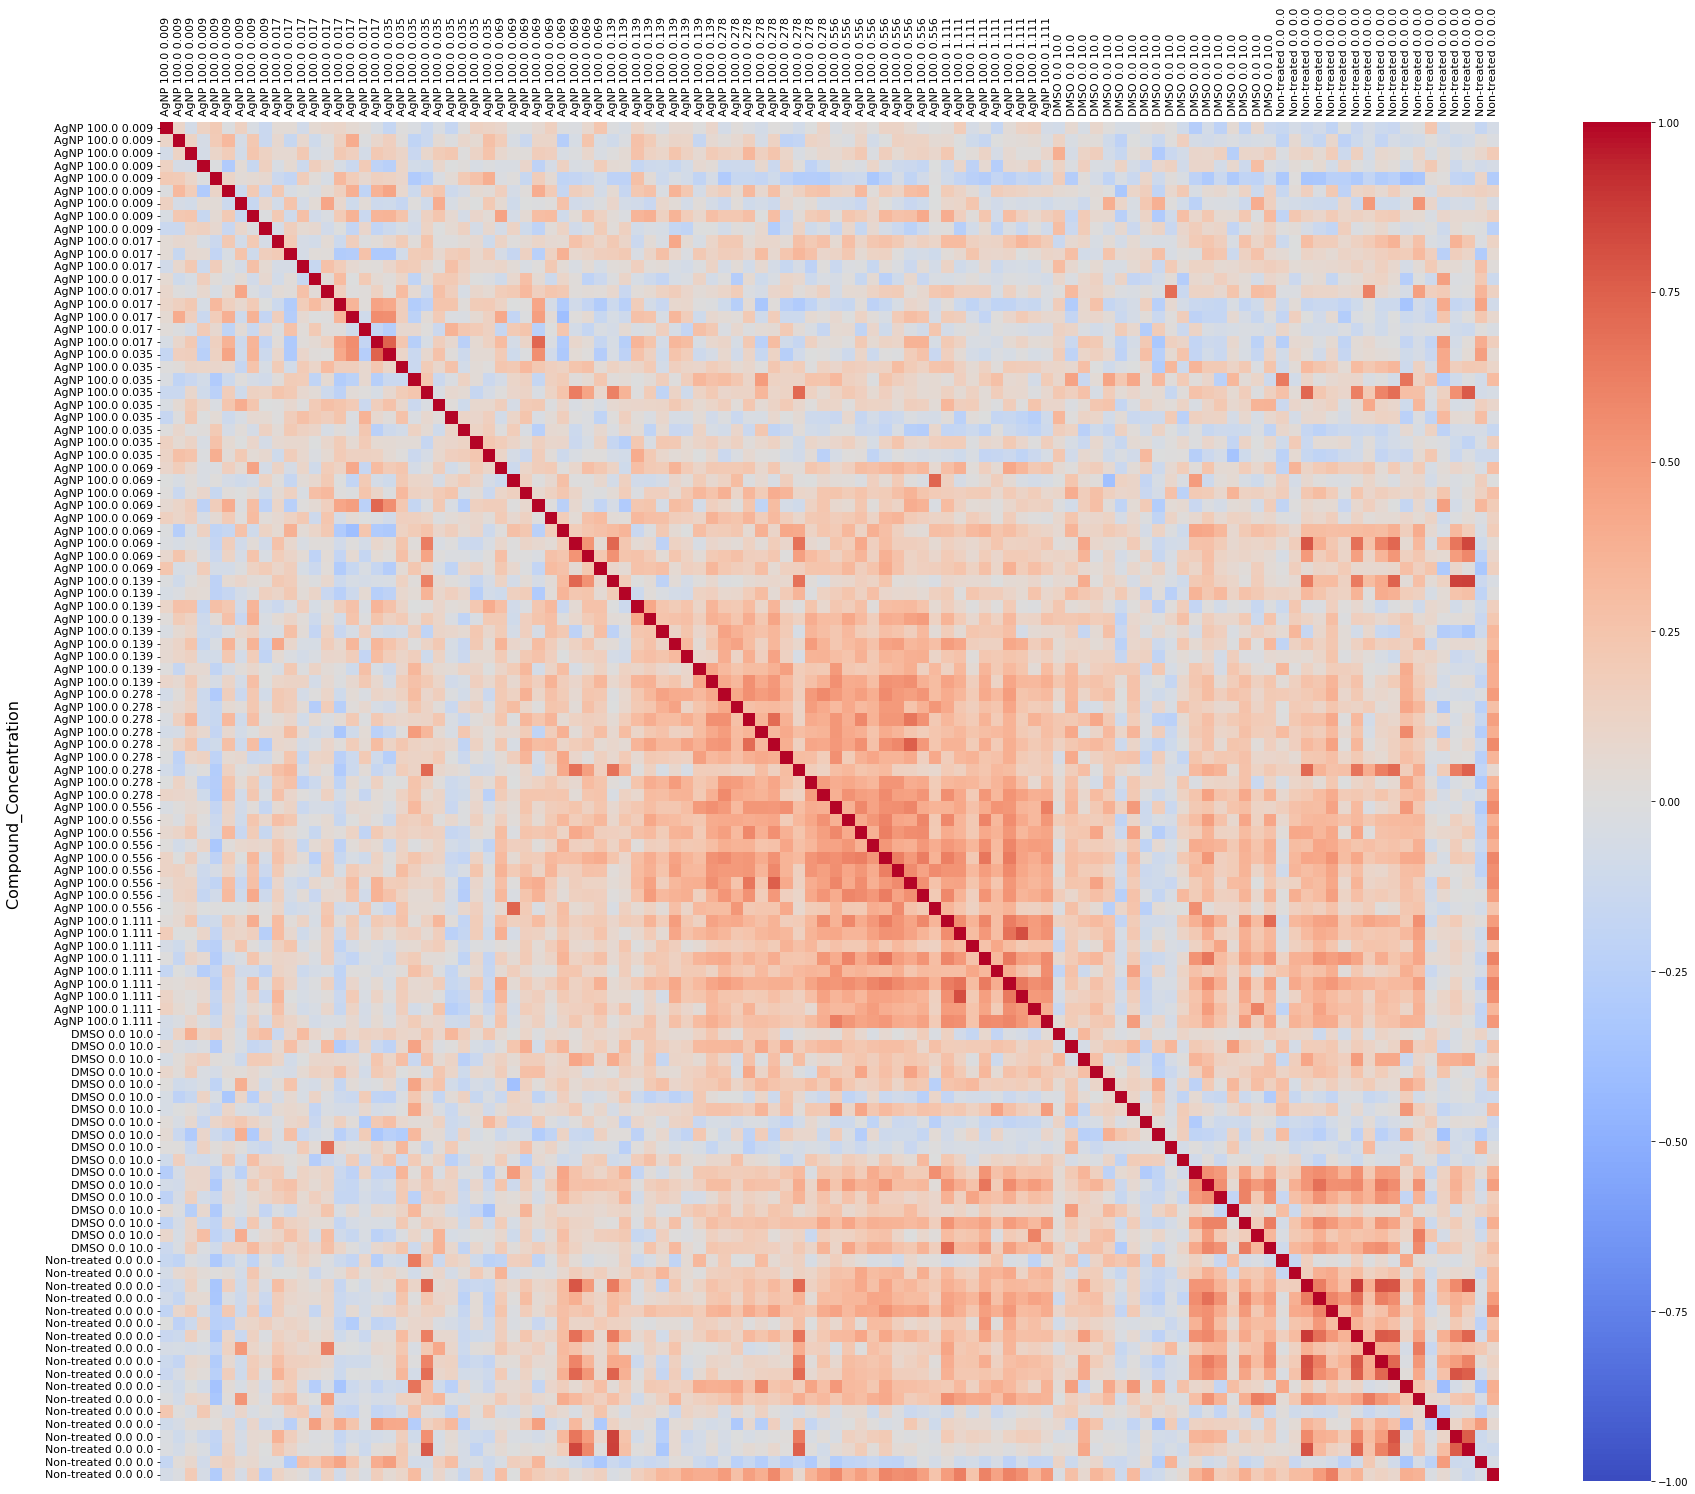

In [12]:
np_list = ['AgNP 40.0', 'AgNP 100.0']

for np in np_list:
    common_list = ['Non-treated 0.0', 'DMSO 0.0']
    input_list = common_list.append(np)
    df_temp = util.corr_matrix_per_plate(df_selected, plates, plot_joined_replicates=True, metadata_column = 'Cells_CompoundSizeCnc',
                                    filter=True, filter_col='Metadata_CompoundSize', filter_list = common_list)
    util.plot_corr_matrix(df_temp, labelsize=11)

# Generate correlation pairs 

- All correlations except the diagonal and duplicated values

In [10]:
corr_pairs = util.correlation_pairs(df_corr)
print('Number of pairs inside one dataframe', len(corr_pairs[0]))

Number of pairs inside one dataframe 16110


# Dictionaries for each plate

- Choose dmso = True when you want to compare the similarity of the compounds against DMSO

In [11]:
main_dict = util.create_dict(corr_pairs, list_cmp, dmso = False, negcon=False, poscon=False)

In [12]:
len(main_dict)

2

# From dictionaries, generate x, y, x_log to plot 

In [13]:
df_dict = util.df_x_y(main_dict)

In [14]:
print(len(df_dict))

2


# Define if plot will be per plate or per assay

In [15]:
df_list = util.df_list_plot(df_dict, plot_joined_replicates=True)

# Plot values with linear regression

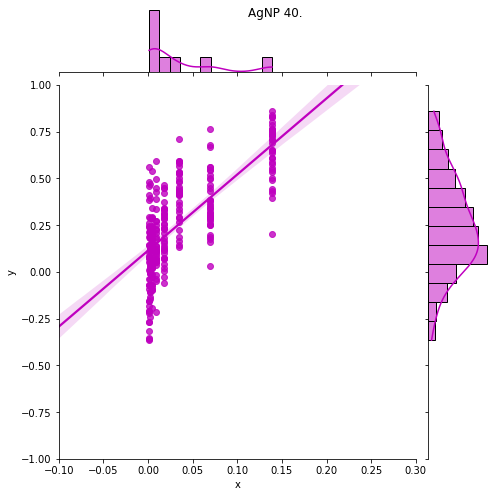

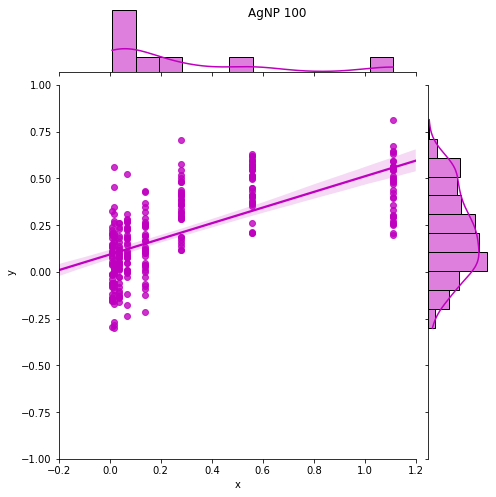

In [16]:
util.plot_linear_regression(df_list)

# Generate non-linear regression plots and save EC50 into dataframe

R-squared: 0.5528106707881217
The EC50 is 29389886.546 micromolar or 293898.8655 mg/mL


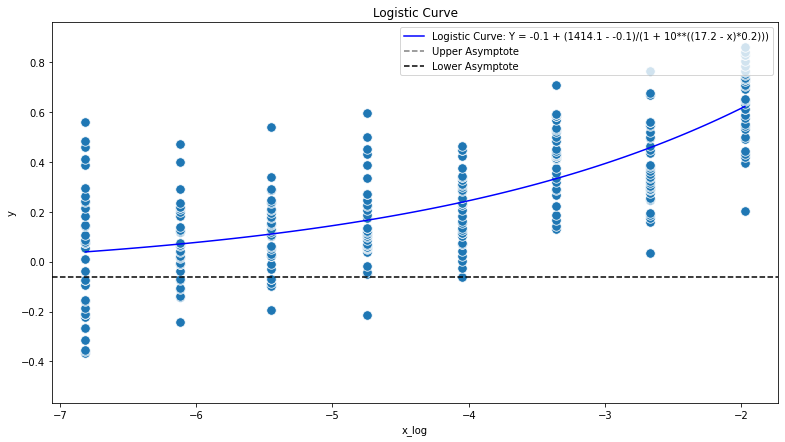

R-squared: 0.5802973592669475
The EC50 is 0.206 micromolar or 0.0021 mg/mL


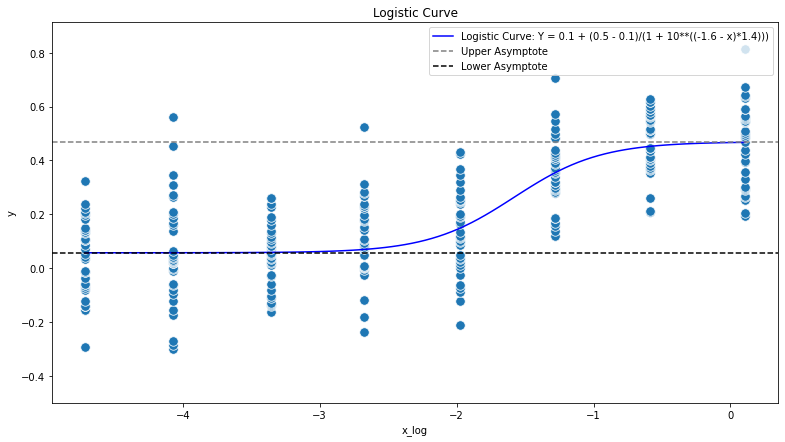

In [17]:
# util.dose_response_generator(df_list, define_bottom = True, bottom = 0)
util.dose_response_generator(df_list)

# Plot dose response curve with feature value

In [18]:
df_feat = pd.DataFrame({'feature':df_selected['Cells_Mean_Vesicles_Intensity_MADIntensity_CorrPI'], 'label':df_selected['Cells_CompoundSizeCnc']})

In [19]:
key = df_feat['label'].to_list()
values = df_feat['feature'].to_list()

In [20]:
main_dict = []
# for plate in range(len(df)):
dict_40 = {}
dict_100 = {}
for cmp in list_cmp:
    keep = []
    keep_negcon = []
    keep_poscon = []
    for i in range(len(key)):
        if key[i] == cmp:
            keep.append(values[i])
    if 'AgNP 40' in cmp:
        dict_40[cmp] = keep
    if 'AgNP 100' in cmp:
        dict_100[cmp] = keep

main_dict.append(dict_40)
main_dict.append(dict_100)

In [21]:
df_dict = util.df_x_y(main_dict)

In [22]:
df_list = util.df_list_plot(df_dict, plot_joined_replicates=False)

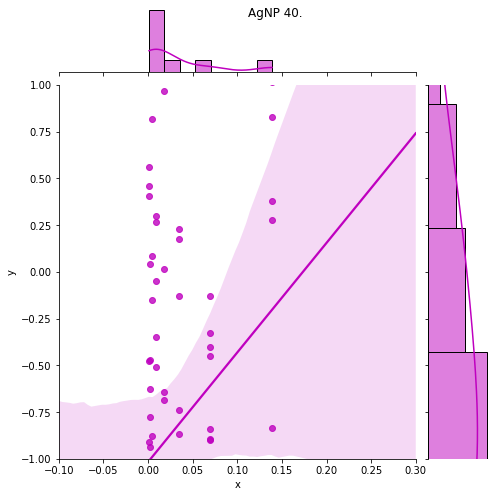

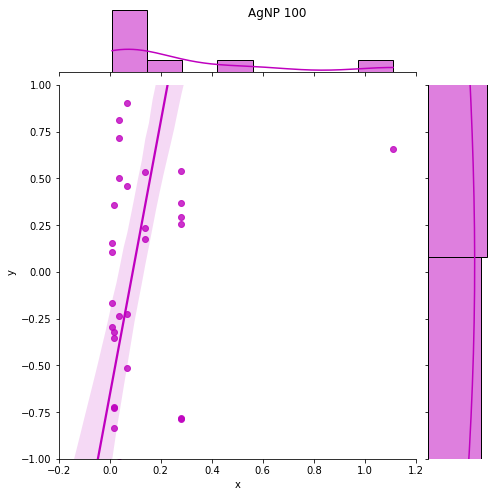

In [23]:
util.plot_linear_regression(df_list)

R-squared: 0.05417861793603951
The EC50 is 0.037 micromolar or 0.0004 mg/mL


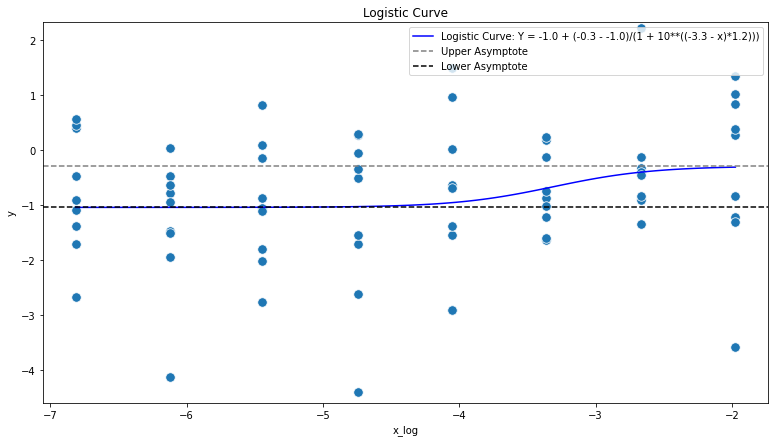

R-squared: 0.6764218571544858
The EC50 is 0.694 micromolar or 0.0069 mg/mL


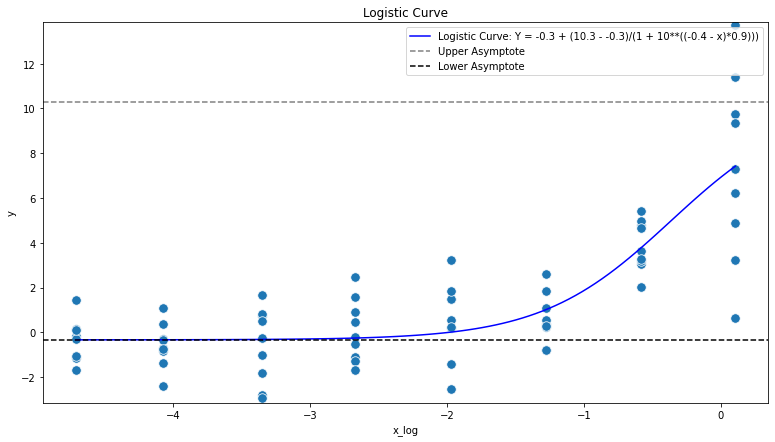

In [24]:
util.dose_response_generator(df_list)
# util.dose_response_generator(df_list, define_bottom = True, bottom = 0)